# Laser Ablation Data Reduction in Python part 2: 
## Calculating concentrations from LA-ICP-MS data
***Jordan Lubbers***<br>
*W.M. Keck Collaboratory for Plasma Spectrometry* <br>
*College of Earth, Ocean, and Atmospheric Sciences* <br>
*Oregon State University* <br>



We can calculate a concentration of analyte ($i$) in an unknown material ($u$) using the following relationship from [Longerich et al., (1996)](https://pubs.rsc.org/en/content/articlepdf/1996/ja/ja9961100899?casa_token=wzlsHfnX2isAAAAA:9eacDWSUwCiphCgC6M2ojwehw8yItKjyC1bnnOowEEKO1XWjPMdAY3fRfvRzWL6BtypMdmMrrBWJupkQ):

$$\Large{{C_i}^u = \frac{{R_i}^u}{S} }$$

Where ${C_i}^u$ and ${R_i}^u$ are the concentration of analyte and count rate of analyte ($i$) in the unknown material, respectively, and $S$ is the normalized sensitivity. When using naturally occuring internal standards, $S$ can be defined as:

$$ \Large{S = \frac{{R_i}^{std}}{{C_i}^{std}}\left[\frac{{R_{n}}^u}{{R_{n}}^{std}} \frac{{C_{n}}^{std}}{{C_{n}}^{u}} \right]  }$$

Where ${R_i}^{std}$ and ${C_i}^{std}$ are the count rate and and concentration of analyte ($i$) in the calibration standard, ${R_{n}}^u$ and ${R_{n}}^{std}$ are the count rates of the internal standard in the unknown material and calibration standard, ${C_{n}}^{u}$ and ${C_{n}}^{std}$ are the concentrations of the internal standard in the unknown material and calibration standard. 

[Kent and Ungerer (2006)](https://pubs.geoscienceworld.org/msa/ammin/article-abstract/91/8-9/1401/134304/Analysis-of-light-lithophile-elements-Li-Be-B-by?redirectedFrom=fulltext) re-arrange this relationship such that the count rate expressions always containin unknown analytes in the numerator:

$$\Large{ {C_i}^u = {C_n}^u \frac{\left[\frac{{C_i}^{std}}{{C_n}^{std}}\right]}{\left[\frac{{R_i}^{std}}{{R_n}^{std}}\right]}\frac{{R_i}^u}{{R_{n}}^u}} $$ 


Below we will walk through how to do this "by hand" in python. The data have already had their count rate ratios calculated and the analyte used as the internal standard will be listed in the ```norm``` column of the input data. Data from the W.M Keck Collaboratory for Plasma Spectrometry at Oregon State University commonly uses $^{43}Ca$ or $^{29}Si$ for silicate minerals.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from statsmodels.tools.eval_measures import rmse
import statsmodels.api as sm
import re
import seaborn as sns

# Import data

Here we bring in our spreadsheet with data that has been normalized to an internal standard as well as a spreadsheet with [GEOREM](http://georem.mpch-mainz.gwdg.de/sample_query_pref.asp) preferred values for all of the standards used in the lab. We set the index to be each spot so that we can access a given analyte for any spot using standard pandas notation:
```python
#grab the normalized 48Ti value for spot BCR-2G_23
test_data.loc['BCR-2G_23','48Ti']

#grab all of the normalized ratios and their uncertainties for spot BCR-2G_23
test_data.loc['BCR-2G_23',:]

```



In [2]:
#import published standards data
stds_data = pd.read_excel('.../laicpms_stds_tidy.xlsx').set_index('Standard')

#import our internal standard normalized data
test_data = pd.read_excel('.../LaserTRAM_Dash_test.xlsx').dropna().set_index('Spot')

test_data.insert(loc = 0,
                 column = 'index',
                 value = np.arange(1,len(test_data)+1))


## Get analysis info
- spots
- possible calibration standards
- experiment analytes

In [3]:
myspots = test_data.index.unique().tolist()
pubstandards = stds_data.index.unique().tolist()
#list of columns that pertain to analytes
myanalytes = [analyte for analyte in test_data.columns.tolist() if not ('_se' in analyte or 'norm' in analyte or 'index' in analyte or 'start' in analyte or 'stop' in analyte)]
myanalytes.remove(test_data['norm'].unique()[0])
#list of columns that pertain to analyte uncertainties
myuncertainties = [analyte + '_se' for analyte in myanalytes]

# Calibration Standard
For this experiment we will use BCR-2G as our calibration standard. Therefore we want to check where in our dataframe samples are BCR-2G analyses and save them as their own dataframe. We then get the average, standard deviation, and relative standard error. 

Below we plot how the normalized ratio for each element changes through time for our calibration standard. While little to no variation is ideal, small changes may be present due to small heterogeneities in standard material composition or drift in the mass spectrometer. 

In [4]:
# Check for potential calibration standards. This will let us know what our options
#are for choosing calibration standards by looking for spots that have the same string 
#as the standard spreadsheet 

#Create a column in our dataframe to denote sample. 
samples = [spot.split('_')[0] for spot in myspots]
test_data['sample'] = samples
test_data.reset_index(inplace = True)
test_data.set_index('sample',inplace = True)

def get_calibration_standards(samples,pubstandards):

    potential_standards = []
    for sample in samples:
        if sample in pubstandards:
            potential_standards.append(sample)

    potential_standards = list(np.unique(potential_standards))
    return potential_standards

potential_standards = get_calibration_standards(samples,pubstandards)
print('Your potential calibration standards are:')
for standard in potential_standards:
    print(standard)


Your potential calibration standards are:
ATHO-G
BCR-2G
BHVO-2G
NIST-612


In [5]:
#Choosing our calibration standard
calib_std = 'BCR-2G'

#create a separate dataframe for our calibration standard data 
calib_std_data = test_data.loc[calib_std,:]




In [6]:
#Calibration standard information
#mean
calib_std_means = calib_std_data.loc[:,myanalytes+myuncertainties].mean()
#std deviation
calib_std_stds = calib_std_data.loc[:,myanalytes+myuncertainties].std()
#relative standard error
calib_std_ses = 100*((calib_std_stds/calib_std_means) / np.sqrt(calib_std_data.shape[0]))
        

In [7]:
#Get a list of all of the elements supported in the published standard datasheet
#Get a second list for the same elements but their corresponding uncertainty columns
standard_elements = [analyte for analyte in stds_data.columns.tolist() if not ('_std' in analyte)]
standard_uncertainties = [analyte + '_std' for analyte in standard_elements]

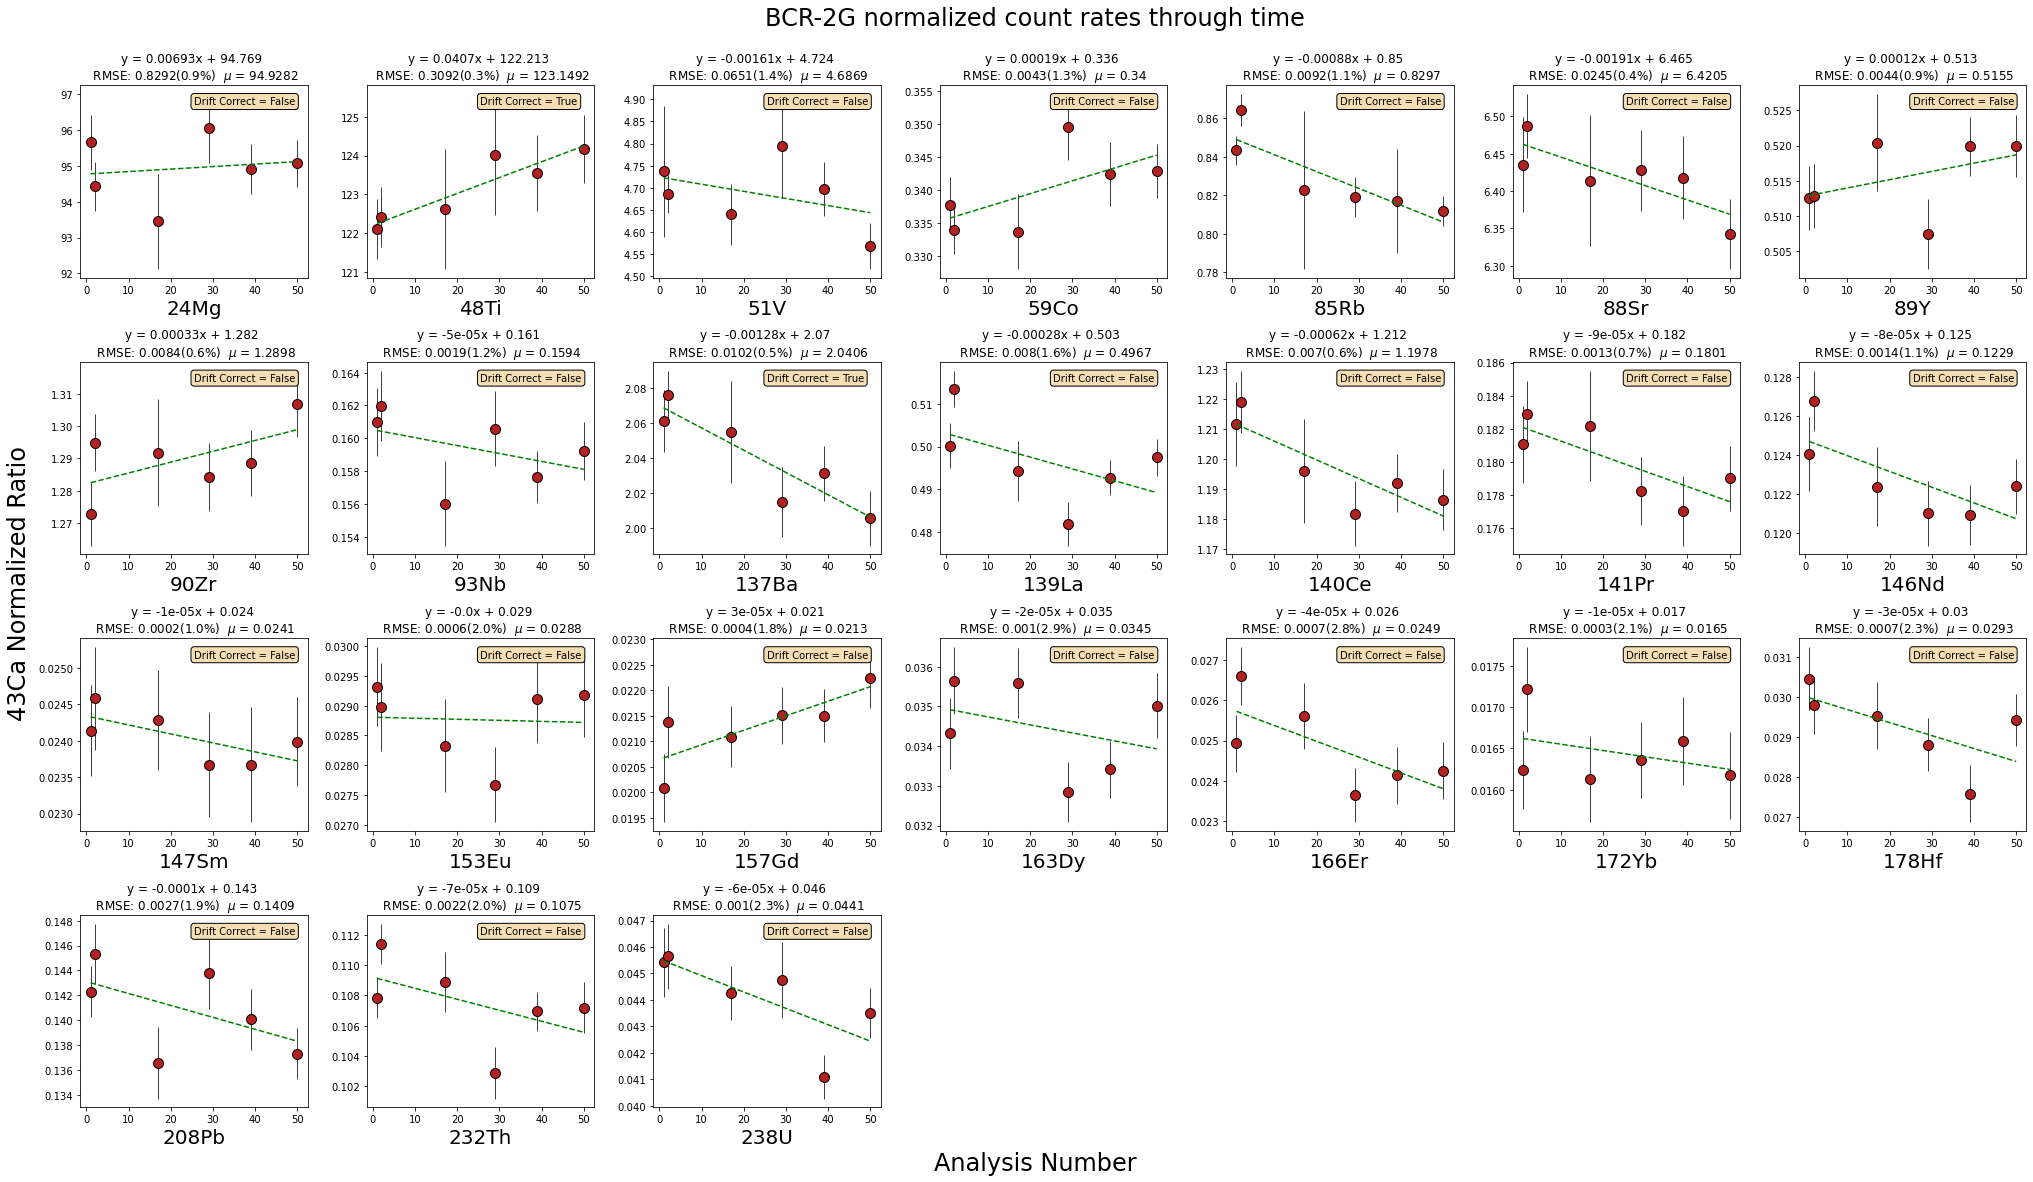

In [8]:

calib_std_rmses = []
calib_std_slopes = []
calib_std_intercepts = []
drift_check = []

#For our calibration standard, calculate the concentration ratio of each analyte to the element used as the internal standard
std_conc_ratios = []
myanalytes_nomass = []

fig,ax = plt.subplots(4,int(len(myanalytes)/4)+1,figsize = ((int(len(myanalytes)/4)+1)*4,16))


axes = ax.ravel()

props = dict(boxstyle='round', facecolor='wheat', alpha=1)
for j in range(len(myanalytes)):
    
    #Getting regression statistics on analyte normalized ratios through time
    #for the calibration standard. This is what we use to check to see if it needs 
    #to be drift corrected
    x = calib_std_data['index']
    y = calib_std_data[myanalytes[j]]
    
    X = sm.add_constant(x)
    # Note the difference in argument order
    model = sm.OLS(y, X).fit()
    # now generate predictions
    ypred = model.predict(X)

    # calc rmse
    RMSE = rmse(y, ypred)
    
    calib_std_rmses.append(RMSE)
    calib_std_slopes.append(model.params[1])
    calib_std_intercepts.append(model.params[0])
    
    

    
    axes[j].errorbar(x , y,
                     yerr = calib_std_data[myanalytes[j]]*(calib_std_data['{}_se'.format(myanalytes[j])]/100),
                     fmt = 'o',
                     mfc = 'firebrick',
                     mec = 'k',
                     ecolor = 'k',
                     elinewidth = .75,
                     zorder = 0,
                     ms = 10
                     
               
               )
    
    axes[j].plot(x,ypred,'g--')
    axes[j].set_xlabel(myanalytes[j],fontsize = 20)

    axes[j].set_title('y = {}x + {} \n RMSE: {}({}%)  $\mu$ = {}'.format(
        np.round(model.params[1],5),
        np.round(model.params[0],3),
        np.round(RMSE,4),
        np.round((100*RMSE/calib_std_means[j]),1),
        np.round(calib_std_means[j],4)
    )
                     )
    
    if 100*RMSE/calib_std_means[j] < calib_std_ses[j]:
        axes[j].text(.5,.9,'Drift Correct = True',transform = axes[j].transAxes,bbox = props)
        drift_check.append('True')
        
        
    else:
        axes[j].text(.5,.9,'Drift Correct = False',transform = axes[j].transAxes,bbox = props)
        drift_check.append('False')
    

    
for j in range(len(axes)):        
    if j >= len(myanalytes):
        fig.delaxes(axes[j])

fig.suptitle('{} normalized count rates through time'.format(calib_std),fontsize = 24,y = 1)
fig.text(0.5, -0.01, 'Analysis Number', ha='center',fontsize = 24,)
fig.text(-0.01, 0.5, '{} Normalized Ratio'.format(calib_std_data['norm'].unique()[0]), va='center', rotation='vertical',fontsize = 24)

fig.tight_layout()
plt.savefig('.../lasercalc_driftcorrect_example.pdf',bbox_inches = 'tight')

In [9]:

#For our calibration standard, calculate the concentration ratio of each analyte to the element used as the internal standard
std_conc_ratios = []
myanalytes_nomass = []

for i in range(len(myanalytes)):
    #strip the atomic number from our analyte data 
    nomass = re.split('(\d+)',myanalytes[i])[2]
    #make it a list
    myanalytes_nomass.append(nomass)
        
    
    #if our element is in the list of standard elements take the ratio
    if nomass in standard_elements:
        std_conc_ratios.append(stds_data.loc[calib_std,nomass]/stds_data.loc[calib_std,re.split('(\d+)',calib_std_data['norm'].unique()[0])[2]])
        

# make our list an array for easier math going forward
# std_conc_ratios = pd.DataFrame(np.array(std_conc_ratios)[np.newaxis,:],columns = myanalytes)
std_conc_ratios = np.array(std_conc_ratios)


# Apply the Kent and Ungerer equation
Becuase we are checking this with ATHO-G and BHVO-2G standards we can also get both the concentration and uncertainty information of the internal standard of our "unknowns" in the published standard spreadsheet. 


## For unknowns that are not secondary standards:

1. if you believe that the concentration of the internal standard is uniform across all your unknowns, input it below in the ```int_std_oxide``` variable below.

2. if you believe that the concentration of the internal standard is NOT uniform across all your unknowns:
    - bring in the concentrations from an excel workbook (recommended)
    - create a representative array in python with the correct internal standard oxide concentrations:
    
# Drift correction
To check for drift in calibration standard normalized ratios over time, a linear regression is applied to each analyte where the dependent variable is the count rate normalized to the internal standard and the independent variable is the analysis number (i.e., the green lines in the above figure). This regression then receives an RMSE value. A linear drift correction is applied to an analyte if the relative RMSE value for a given analyte is less than the standard error of the mean. The only way this happens is if there is a linear change in normalized count rates over time that will drive the RMSE of the regression to lower values while the standard error of the mean will increase. This drift correction then uses the regression parameters (e.g., slope and intercept) to calculate a normalized countrate for the calibration standard at the point in time where an unknown was analyzed: 


$$\Large{ {C_i}^u = {C_n}^u \frac{\left[\frac{{C_i}^{std}}{{C_n}^{std}}\right]}{\left[m_ix +b_i\right]}\frac{{R_i}^u}{{R_{n}}^u}} $$ 

where $m$ is the regression slope, $x$ is the analysis number, and $b$ is the intercept for analyte $i$.


    



In [10]:
def oxide_to_ppm(oxide,int_std):
    if int_std == '43Ca':
        ppm = 1e4*(oxide*40.078 / (40.078 + 15.999))
    elif int_std == '29Si':
        ppm = 1e4*(oxide*28.086 / (28.086 + 15.999) )  
    return ppm

#all of the samples in your input sheet that are NOT potential calibration standards
samples_nostandards = list(np.setdiff1d(samples,potential_standards)) 

# wt% oxide of internal standard in unknown
int_std_oxide = 0.9

#turning the scalar value into a 1D array that is the same length of the data that are NOT potential internal
#standards. 
int_std_oxide_array = np.full(test_data.loc[samples_nostandards,:].shape[0],int_std_oxide)

#converting wt% oxide to ppm or ug/g. This is a scalar value
int_std_concentration = oxide_to_ppm(int_std_oxide_array,calib_std_data['norm'].unique()[0])





In [11]:
secondary_standards = potential_standards.copy()
secondary_standards.remove(calib_std)
concentrations_list = []


     
        
for standard in secondary_standards:
    drift_concentrations_list = []

    
    for j,analyte, slope, intercept,drift in zip(range(len(myanalytes)),myanalytes,calib_std_slopes,calib_std_intercepts,drift_check):        
        
        
        if 'True' in drift:
            
            frac = slope*test_data.loc[standard,'index']+intercept
            
            drift_concentrations = (stds_data.loc[standard,re.split('(\d+)',calib_std_data['norm'].unique()[0])[2]])*(std_conc_ratios[j]/frac)*test_data.loc[standard,analyte]
            
            df = pd.DataFrame(drift_concentrations,columns = [analyte])

            drift_concentrations_list.append(df)
            
    drift_df = pd.concat(drift_concentrations_list,axis = 'columns')
    
            
            

    concentrations = (stds_data.loc[standard,re.split('(\d+)',calib_std_data['norm'].unique()[0])[2]])*(std_conc_ratios/calib_std_means[myanalytes])*test_data.loc[standard,myanalytes]
    
    for column in drift_df.columns.tolist():
        concentrations[column] = drift_df[column]

    concentrations_list.append(concentrations)
    
    
    
    
#All of our samples that are not potential secondary standards. The concentrations for the internal standard are 
#specified in the cell above


unknown_concentrations_list = []
#creates a list of dataframes, one for each sample, that holds the concentration information

for sample in samples_nostandards:
    
    drift_concentrations_list = []

    
    for j,analyte, slope, intercept,drift in zip(range(len(myanalytes)),myanalytes,calib_std_slopes,calib_std_intercepts,drift_check):        
        
        
        if 'True' in drift:
            
            frac = slope*test_data.loc[sample,'index']+intercept
            
            drift_concentrations = test_data.loc[sample,analyte]*(std_conc_ratios[j]/frac)*(int_std_concentration)
            
            df = pd.DataFrame(drift_concentrations,columns = [analyte])

            drift_concentrations_list.append(df)
            
    drift_df = pd.concat(drift_concentrations_list,axis = 'columns')
    
    
    unknown_concentrations = test_data.loc[sample,myanalytes]*(std_conc_ratios/calib_std_means[myanalytes])*(int_std_concentration[:,np.newaxis])
    
 
    
    
    for column in drift_df.columns.tolist():
        unknown_concentrations[column] = drift_df[column]

    unknown_concentrations_list.append(unknown_concentrations)


# Uncertainties
Uncertainties in calculated concentrations can be calculated according to standard error propagation of uncertainties in products and quotients ([Taylor 1997 p. 61](http://hep.ucsb.edu/courses/ph128_18f/Taylor.pdf)):

$$ \frac{\sigma_q}{\lvert q \rvert}  = \sqrt{\left(\frac{\sigma_x}{\lvert x\rvert}\right)^2+\left(\frac{\sigma_y}{\lvert y\rvert}\right)^2+\left(\frac{\sigma_z}{\lvert z\rvert}\right)^2+...\left(\frac{\sigma_n}{\lvert n\rvert}\right)^2}$$

Because the formula for calculating concentrations of a given analyte in an unknown material is just a series of nested quotients and products we can explain the overall uncertainty of a given analyte as:

$$ \large{ \sigma_{C_i} = {C_i}^u \sqrt{ \left( \frac{\sigma_{{C_u}^{n}}}{{C_u}^{n}}\right)^2 + \left( \frac{\sigma_{{C_i}^{std}}}{{C_i}^{std}}\right)^2 + \left( \frac{\sigma_{{C_n}^{std}}}{{C_n}^{std}}\right)^2 + \left( \frac{\sigma_{{R_i}^{std}}}{{R_i}^{std}}\right)^2 + \left( \frac{\sigma_{{R_n}^{std}}}{{R_n}^{std}}\right)^2 + \left( \frac{\sigma_{{R_i}^{u}}}{{R_i}^{u}}\right)^2 + \left( \frac{\sigma_{{R_n}^{u}}}{{R_n}^{u}}\right)^2 }}$$

We can further simplify this as we have already calculated values and relative uncertainties on the normalized count rates for both the calibration standard:

- $ \frac{{R_i}^{std}}{{R_n}^{std}} = $ normalized count rate in the calibration standard 
- $ \frac{{R_i}^{u}}{{R_n}^{u}} = $ normalized count rate in the unknown

Therefore, our final uncertainty relationship is as follows:

$$ \large{ \sigma_{C_i} = {C_i}^u \sqrt{ \left( \frac{\sigma_{{C_u}^{n}}}{{C_u}^{n}}\right)^2 + \left( \frac{\sigma_{{C_i}^{std}}}{{C_i}^{std}}\right)^2 + \left( \frac{\sigma_{{C_n}^{std}}}{{C_n}^{std}}\right)^2 + \left( \frac{\sigma_{{N_i}^{std}}}{{N_i}^{std}}\right)^2 + \left( \frac{\sigma_{{N_i}^{u}}}{{N_i}^{u}}\right)^2}}$$

where $N_i$ is now the normalized count rate a given analyte ($i$) to the internal standard ($n$). 

For analytes where drift correction has been applied, $\frac{\sigma_{{N_i}^{std}}}{{N_i}^{std}}$ is replaced with:

$$ 100\left[\frac{RMSE_i}{\mu_i}\right] $$

where $\mu$ is the mean of the count rate normalized to the internal standard for analyte $i$







In [12]:
calib_uncertainty = True
stds_list = []
unknowns_list = []
#relative uncertainty in % of the concentration of the internal standard
#in the unknown
unknown_int_std_unc = 3

#use RMSE of regression for elements where drift correction is applied rather than the standard error
# of the mean of all the calibration standard normalized ratios
for j in range(len(drift_check)):
    if 'True' in drift_check[j]:
        calib_std_means[j] = 100*calib_std_rmses[j]/calib_std_means[j]

#creates a list of dataframes that hold the uncertainty information for each secondary standard. 
for standard,concentration in zip(secondary_standards,concentrations_list):
    

    #concentration of internal standard in unknown uncertainties
    t1 = (stds_data.loc[standard,'{}_std'.format(re.split('(\d+)',calib_std_data['norm'].unique()[0])[2])] / stds_data.loc[standard,'{}'.format(re.split('(\d+)',calib_std_data['norm'].unique()[0])[2])])**2

    #concentration of internal standard in calibration standard uncertainties
    t2 = (stds_data.loc[calib_std,'{}_std'.format(re.split('(\d+)',calib_std_data['norm'].unique()[0])[2])] / stds_data.loc[calib_std,'{}'.format(re.split('(\d+)',calib_std_data['norm'].unique()[0])[2])])**2

    #concentration of each analyte in calibration standard uncertainties
    std_conc_stds = []
    for i in range(len(myanalytes)):
        #strip the atomic number from our analyte data 
        nomass = re.split('(\d+)',myanalytes[i])[2]

        #if our element is in the list of standard elements take the ratio
        if nomass in standard_elements:
            std_conc_stds.append((stds_data.loc[calib_std,'{}_std'.format(nomass)]/stds_data.loc[calib_std,nomass])**2)

    std_conc_stds = np.array(std_conc_stds)



    #Overall uncertainties

    if calib_uncertainty == True:
        stds_values = concentration*np.sqrt(t1+ t2 + std_conc_stds + (calib_std_ses[myanalytes].to_numpy()[np.newaxis,:]/100)**2 + ((test_data.loc[standard,myuncertainties].to_numpy()/100)/test_data.loc[standard,myanalytes].to_numpy())**2)
        stds_values.columns = myuncertainties
        stds_list.append(stds_values)
    else:
        stds_values = concentration*np.sqrt(t2 + std_conc_stds + (calib_std_ses[myanalytes].to_numpy()[np.newaxis,:]/100)**2 + ((test_data.loc[standard,myuncertainties].to_numpy()/100)/test_data.loc[standard,myanalytes].to_numpy())**2)
        stds_values.columns = myuncertainties
        stds_list.append(stds_values)   

        
   


# creates a list of dataframes that hold the uncertainty information for unknown spot. 
for sample,concentration in zip(samples_nostandards,unknown_concentrations_list):
    

    #concentration of internal standard in unknown uncertainties
    t1 = (unknown_int_std_unc/100)**2

    #concentration of internal standard in calibration standard uncertainties
    t2 = (stds_data.loc[calib_std,'{}_std'.format(re.split('(\d+)',calib_std_data['norm'].unique()[0])[2])] / stds_data.loc[calib_std,'{}'.format(re.split('(\d+)',calib_std_data['norm'].unique()[0])[2])])**2

    #concentration of each analyte in calibration standard uncertainties
    std_conc_stds = []
    for i in range(len(myanalytes)):
        #strip the atomic number from our analyte data 
        nomass = re.split('(\d+)',myanalytes[i])[2]

        #if our element is in the list of standard elements take the ratio
        if nomass in standard_elements:
            std_conc_stds.append((stds_data.loc[calib_std,'{}_std'.format(nomass)]/stds_data.loc[calib_std,nomass])**2)

    std_conc_stds = np.array(std_conc_stds)




    if calib_uncertainty == True:
        unknown_stds_values = concentration*np.sqrt(t1+ t2 + std_conc_stds + (calib_std_ses[myanalytes].to_numpy()[np.newaxis,:]/100)**2 + ((test_data.loc[sample,myuncertainties].to_numpy()/100)/test_data.loc[sample,myanalytes].to_numpy())**2)
        unknown_stds_values.columns = myuncertainties
        unknowns_list.append(unknown_stds_values)
    else:
        unknown_stds_values = concentration*np.sqrt(t2 + std_conc_stds + (calib_std_ses[myanalytes].to_numpy()[np.newaxis,:]/100)**2 + ((test_data.loc[sample,myuncertainties].to_numpy()/100)/test_data.loc[sample,myanalytes].to_numpy())**2)
        unknown_stds_values.columns = myuncertainties
        unknowns_list.append(unknown_stds_values) 




In [13]:
final_standards_list = []
final_unknowns_list = []
#concatenates the concentrations and uncertainties dataframes such that there is now one dataframe for each 
#secondary standard that contains both the concentrations and concentrations of the uncertainties for each spot

for concentration, standard, name in zip(concentrations_list,stds_list,secondary_standards):
    df = pd.concat([concentration,standard],axis = 1)
    df[df < 0] = 'b.d.l.'
    df.insert(loc = 0,
              column = 'Spot',
              value = test_data.loc[name,'Spot']
             )
    if calib_std_data['norm'].unique()[0] == '43Ca':
        df.insert(loc = 1,
                  column = 'CaO',
                  value = stds_data.loc[name,'CaO']/1e4
        
        )
        df.insert(loc = 2,
                  column = 'CaO_std%',
                  value = (stds_data.loc[name,'CaO_std'] / stds_data.loc[name,'CaO'])*100
        
        )
        
    elif calib_std_data['norm'].unique()[0] == '29Si':
        df.insert(loc = 1,
                  column = 'SiO2',
                  value = stds_data.loc[name,'SiO2']/1e4
        
        )
        df.insert(loc = 2,
                  column = 'SiO2_std%',
                  value = (stds_data.loc[name,'SiO2_std'] / stds_data.loc[name,'SiO2'])*100
        
        )

   
    final_standards_list.append(df)

for concentration, sample, name in zip(unknown_concentrations_list,unknowns_list,samples_nostandards):
    df = pd.concat([concentration,sample],axis = 1)
    df[df < 0] = 'b.d.l.'
    df.insert(loc = 0,
              column = 'Spot',
              value = test_data.loc[name,'Spot']
    
    )
    if calib_std_data['norm'].unique()[0] == '43Ca':
        df.insert(loc = 1,
                  column = 'CaO',
                  value = int_std_oxide
        
        )
        df.insert(loc = 2,
                  column = 'CaO_std%',
                  value = unknown_int_std_unc
        
        )
        
    elif calib_std_data['norm'].unique()[0] == '29Si':
        df.insert(loc = 1,
                  column = 'SiO2',
                  value = int_std_oxide
        
        )
        df.insert(loc = 2,
                  column = 'SiO2_std%',
                  value = unknown_int_std_unc
        
        )

    final_unknowns_list.append(df)
    
df_standards = pd.concat(final_standards_list)
df_unknowns = pd.concat(final_unknowns_list)


# Check our work
## Measured vs. accepted

(0.8, 1.2)

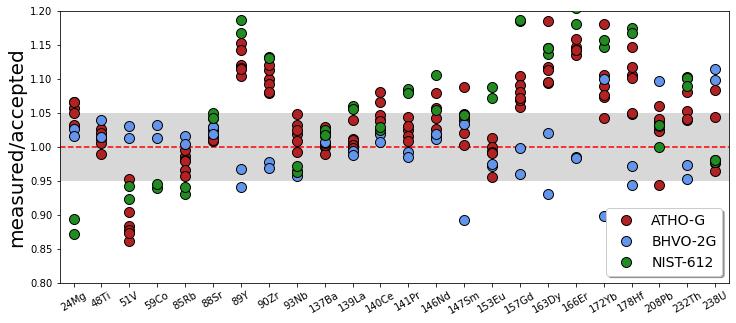

In [14]:
ratios_df = pd.DataFrame(0, index= df_standards.index, columns=myanalytes)
colors = ['firebrick','cornflowerblue','forestgreen']

fig,ax = plt.subplots(figsize = (12,5))
for standard,color in zip(secondary_standards,colors):
    
    for analyte,nomass in zip(myanalytes,myanalytes_nomass):

        ratios_df.loc[standard,analyte] = df_standards.loc[standard,analyte].div(stds_data.loc[standard,nomass])

    


    sns.stripplot(data  = ratios_df.loc[standard,:],fc = color,ec = 'k',linewidth = 1,jitter = False,size = 10,)
    

ax.set_xticklabels(myanalytes,rotation = 30)
ax.set_ylabel('measured/accepted',fontsize = 20)
legend_elements = [Line2D([0], [0], marker='o', color='k', label=secondary_standards[0],ls = '',
                          mfc=colors[0],mec = 'k', markersize=10),
                   Line2D([0], [0], marker='o', color='k', label=secondary_standards[1],ls = '',
                          mfc=colors[1],mec ='k', markersize=10),
                   Line2D([0], [0], marker='o', color='k', label=secondary_standards[2],ls = '',
                          mfc=colors[2],mec ='k', markersize=10),
                   
                  ]
ax.legend(handles = legend_elements,loc = 'lower right',fontsize = 14,fancybox = True,shadow = True)
ax.axhline(1,c = 'r',ls = '--',)
ax.axhspan(.95,1.05,alpha = .3,fc = 'gray',label = '$\pm$5\%')
ax.set_ylim(.8,1.2)



## Bivariate check

Text(0, 0.5, '137Ba [ppm]')

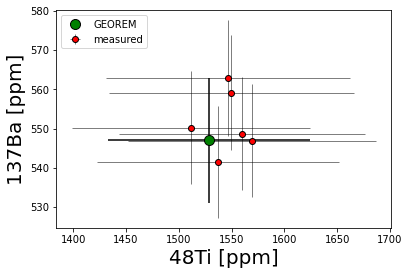

In [15]:
fig,ax = plt.subplots()

x = '48Ti'
y = '137Ba'

ax.errorbar(data = stds_data.loc['ATHO-G',:],x = re.split('(\d+)',x)[2],y = re.split('(\d+)',y)[2],
            fmt = 'o',
            ls = '',
            ecolor = 'k',
            mec = 'k',
            mfc = 'g',
            xerr = 'Ti_std',
            yerr = 'Ba_std',
            ms = 10,
            label = 'GEOREM'
           )

ax.errorbar(data = df_standards.loc['ATHO-G',:],x = x,y = y,
            fmt = 'o',
            ls = '',
            ecolor = 'k',
            elinewidth = .5,
            mec = 'k',
            mfc = 'r',
            xerr = '48Ti_se',
            yerr = '137Ba_se',
            label = 'measured'
           
           )

ax.legend(loc = 'upper left')
ax.set_xlabel('{} [ppm]'.format(x),fontsize = 20)
ax.set_ylabel('{} [ppm]'.format(y),fontsize = 20)



# Export concentrations as Excel workbook

In [16]:
with pd.ExcelWriter('.../lasercalc_python_test.xlsx') as writer:  
    df_unknowns.to_excel(writer, sheet_name='unknowns')
    df_standards.to_excel(writer, sheet_name='secondary standards')
    
    